# Regularização e Gradiente Descendente


## Introdução

Vamos iniciar essa lista com um pequeno tutorial sobre regressão, atributos polinomiais e regularização em uma base de dados bem simples contendo uma coluna de variáveis `x` e um valor `y` associado. A base de dados é chamada de `X_Y_Sinusoid_Data.csv`. 

## Exercício 1

* Importe a base de dados. 
* Gere aproximadamente  100 pontos x na faixa de 0 a 1 utilizando a função `linspace` do `numpy`. Usando esses pontos, calcule o ponto y representando o valor verdadeiro a partir da equação: $y = sin(2\pi x)$

* Plote a base e `x` vs `y` da base e o gerado.


In [36]:
import pandas as pd
import numpy as np

filepath = 'data/X_Y_Sinusoid_Data.csv'
data = pd.read_csv(filepath)

X_real = np.linspace(0.0, 1.0, num=100)
Y_real = np.sin(2*np.pi*X_real)

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

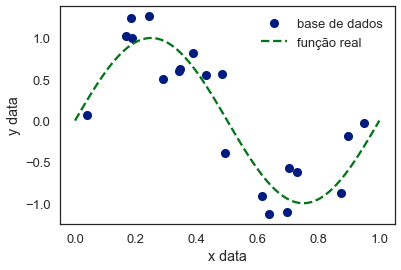

In [38]:
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

# Plot of the noisy (sparse)
ax = data.set_index('x')['y'].plot(ls='', marker='o', label='base de dados')
ax.plot(X_real, Y_real, ls='--', marker='', label='função real')

ax.legend()
ax.set(xlabel='x data', ylabel='y data');

## Exercício 2


* Usando a classe `PolynomialFeatures` da biblioteca de pré-processamento do Scikit-learn's, crie atributos polinomiais de ordem 20.
* Crie um modelo de regressão linear. 
* Plote o valor predito com o valor calculado.

Note que `PolynomialFeatures` requer um dataframe com 1 coluna ou uma array bidimensional de dimensão (`n`, 1), com `n` sendo o número de amostras.

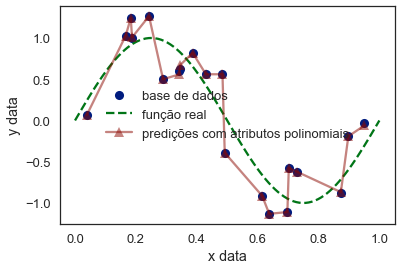

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Setup the polynomial features
degree = 20
pf = PolynomialFeatures(degree)
lr = LinearRegression()

# Extraindo x e y da base de dados no formato correto
X_data = data[['x']]
Y_data = data['y']

# Create the features and fit the model
X_poly = pf.fit_transform(X_data)
lr.fit(X_poly, Y_data)
Y_pred = lr.predict(X_poly)

# Plot the result
plt.plot(X_data, Y_data, marker='o', ls='', label='base de dados', alpha=1)
plt.plot(X_real, Y_real, ls='--', label='função real')
plt.plot(X_data, Y_pred, marker='^', alpha=.5, label='predições com atributos polinomiais')
plt.legend()
ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');


## Exercício 3

* Repita o experimento anterior utilizando ridge regression ($\alpha$=0.001) e lasso regression ($\alpha$=0.0001). 
* Plote os resultados.
* Em seguida vamos plotar a magnitude dos coefientes dos modelos para comparação.

O que a diferença entre as magnitudes te diz sobre a regularização?

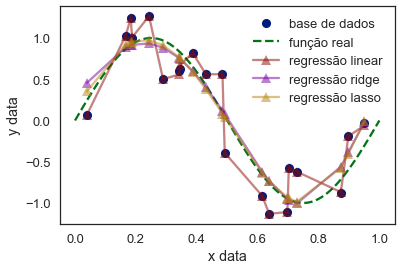

In [40]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

from sklearn.linear_model import Ridge, Lasso

# Crie o modelo Ridge
rr = Ridge(alpha = 0.001)
rr.fit(X_poly, Y_data)
Y_pred_rr = rr.predict(X_poly)

# Crie o modelo Lasso
lassor = Lasso(alpha = 0.0001)
lassor.fit(X_poly, Y_data)
Y_pred_lr = lassor.predict(X_poly)

# Vamos plotar as predições
plt.plot(X_data, Y_data, marker='o', ls='', label='base de dados')
plt.plot(X_real, Y_real, ls='--', label='função real')
plt.plot(X_data, Y_pred, label='regressão linear', marker='^', alpha=.5)
plt.plot(X_data, Y_pred_rr, label='regressão ridge', marker='^', alpha=.5)
plt.plot(X_data, Y_pred_lr, label='regressão lasso', marker='^', alpha=.5)

plt.legend()

ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');

In [41]:
# Vamos examinar os coeficientes gerados pelos modelos
# .ravel() retorna uma array multidimensional concatenada em uma dimensão (flattened)

coefficients = pd.DataFrame()
coefficients['linear regression'] = lr.coef_.ravel()
coefficients['ridge regression'] = rr.coef_.ravel()
coefficients['lasso regression'] = lassor.coef_.ravel()
coefficients = coefficients.applymap(abs)

coefficients.describe()  # Diferença enorme da escala da regressão linear e das regularizações

,linear regression,ridge regression,lasso regression
count,2.100000e+01,21.000000,21.000000
mean,5.777551e+13,2.169397,2.167284
std,6.031941e+13,2.900278,4.706731
min,1.619371e+07,0.000000,0.000000
25%,3.416390e+12,0.467578,0.000000
50%,3.621188e+13,1.017272,0.252181
75%,1.070540e+14,2.883507,1.641353
max,1.655347e+14,12.429635,20.176708


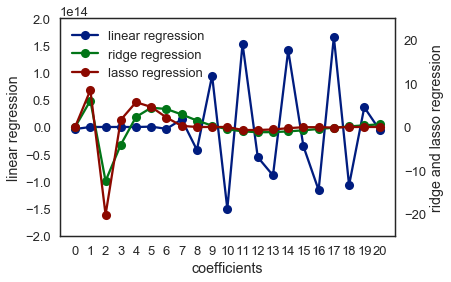

In [42]:
colors = sns.color_palette()

# Vamos criar dois eixos, um para regressão linear outro para as regularizações
ax1 = plt.axes()
ax2 = ax1.twinx()

# Plotar a regressão linear
ax1.plot(lr.coef_.ravel(), 
         color=colors[0], marker='o', label='linear regression')

# Plotar as regularizações no outro eixo
ax2.plot(rr.coef_.ravel(), 
         color=colors[1], marker='o', label='ridge regression')

ax2.plot(lassor.coef_.ravel(), 
         color=colors[2], marker='o', label='lasso regression')

# Alterar as escalas
ax1.set_ylim(-2e14, 2e14)
ax2.set_ylim(-25, 25)

# Combinar as legendas
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)

ax1.set(xlabel='coefficients',ylabel='linear regression')
ax2.set(ylabel='ridge and lasso regression')

ax1.set_xticks(range(len(lr.coef_)));

## Exercício 4

Para os próximos exercícios vamos utilizar a base de dados da atividade anterior sobre o preço dos imóveis.

Para começar:

* Importe os dados com Pandas e aplique o one-hot-encoding nas variáveis categóricas, vamos utilizar o método `.get_dummies`. 
* Divida a base entre treino e teste. 
* Aplique a função de transformação Log nos atributos com viés. 

In [43]:
filepath = 'data/Ames_Housing_Sales.csv'
data1 = pd.read_csv(filepath, sep=',')
data = data1.dropna()

Crie uma lista de atributos categóricos e aplique o método `get_dummies` para gerar os atributos one-hot-encoding.

In [44]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = data.dtypes[data.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Primeiro devemos marcar cada coluna como categórico com pd.Categorical()
for col in one_hot_encode_cols:
    data[col] = pd.Categorical(data[col])

# Agora aplicamos o método get_dummies() nas nossas colunas categóricas
data = pd.get_dummies(data, columns=one_hot_encode_cols)

Agora, vamos dividir a base entre treino e teste, use `test_size=0.3` e `random_state=42`:

In [45]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

Alguns atributos possuem valores enviesados--uma transformação log pode ajudar a aliviar essa situação. Vamos alterar esses atributos, exceto pelo `SalePrice` que é nossa variável alvo.

In [46]:
# Create a list of float colums to check for skewing
mask = data.dtypes == np.float
float_cols = data.columns[mask]

In [47]:
skew_limit = 0.75
skew_vals = train[float_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
MiscVal,26.915364
PoolArea,15.777668
LotArea,11.501694
LowQualFinSF,11.210638
3SsnPorch,10.150612
ScreenPorch,4.599803
BsmtFinSF2,4.466378
EnclosedPorch,3.218303
LotFrontage,3.138032
MasVnrArea,2.492814


Transform all the columns where the skew is greater than 0.75, excluding "SalePrice".

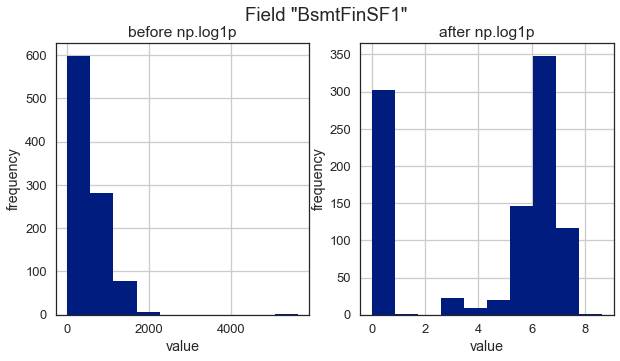

In [48]:
# OPTIONAL: Let's look at what happens to one of these features, when we apply np.log1p visually.

field = "BsmtFinSF1"
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))
train[field].hist(ax=ax_before)
train[field].apply(np.log1p).hist(ax=ax_after)
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));
# a little bit better

In [49]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

for col in skew_cols.index.tolist():
    if col == "SalePrice":
        continue
    # aplique a função np.log1p nessa variável
    train[col] = np.log1p(train[col])
    test[col]  = np.log1p(test[col])
    
train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
461,6.447306,0.000000,0.0,1,6.246107,0.0,1,0,4.753590,0.0,...,0,0,0,0,0,1,0,1,1,0
976,6.740519,0.000000,0.0,3,0.000000,0.0,0,0,0.000000,0.0,...,0,0,0,0,0,1,0,1,1,0
1128,6.591674,6.591674,0.0,3,0.000000,0.0,0,0,6.591674,0.0,...,0,0,0,0,0,1,0,1,1,0
904,6.331502,6.505784,0.0,2,5.655992,0.0,0,0,5.624018,0.0,...,0,0,0,0,0,1,0,1,1,0
506,7.379008,0.000000,0.0,3,7.214504,0.0,1,0,5.411646,0.0,...,0,0,0,0,0,1,0,1,1,0


Vamos separar os atributos do preditor

In [50]:
feature_cols = [x for x in train.columns if x != 'SalePrice']
X_train = train[feature_cols]
y_train = train['SalePrice']

X_test  = test[feature_cols]
y_test  = test['SalePrice']

y_train.head()

461      86000.0
976      84000.0
1128    176000.0
904     124000.0
506     272000.0
Name: SalePrice, dtype: float64

## Exercício 5

* Escreva a função **`rmse`**  que recebe valores reais da variável alvo e os peditos pelo modelo e retorna a raiz quadrada do erro quadrático médio. Use a função `mean_squared_error` do sklearn.  


In [51]:
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return mean_squared_error(ytrue, ypredicted)

* Aplique um modelo básico de regressão linear
* imprima o rmse do modelo
* plot os valores preditos vs reais baseado no modelo.  

In [52]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
y_predicted = lr.predict(X_test)

linearRegression_rmse = rmse(y_test, y_predicted)

print(linearRegression_rmse)

93862382920.82834


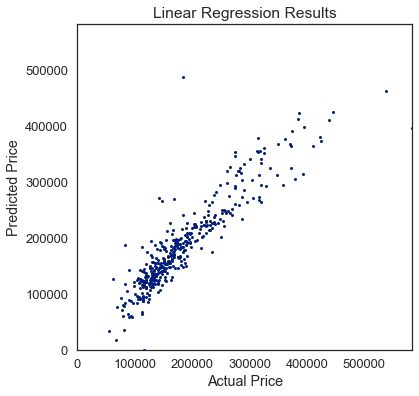

In [53]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, y_predicted, 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

## Exercício 6

A regressão Ridge usa a regularização do tipo L2 para reduzir a magnitude dos coeficientes. Isso é especialmente útil quando temos uma variância muito alta. O Scikit-Learn possui esse modelo na classe `Ridge` e uma versão que aplica validação cruzada para determinar o melhor valor de $\alpha$ na classe `RidgeCV`.

* Utilize a classe `Ridge` e determine o melhor valor de $\alpha$ dentre os valores $$[0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]$$ e plote o RMSE vs $\alpha$.

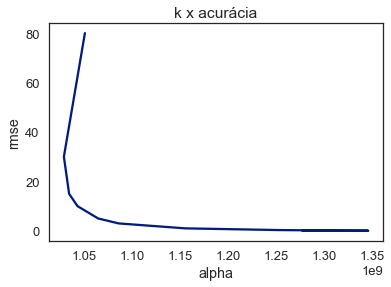

In [63]:
from sklearn.linear_model import Ridge

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

rmses = []

for x in alphas:
    ridge = Ridge(alpha=x)
    ridge.fit(X_train, y_train)
    rmses.append(rmse(y_test, ridge.predict(X_test)))

plt.title('k x acurácia')    
plt.xlabel('alpha')
plt.ylabel('rmse')

plt.plot(rmses, alphas)

Agora repita o experimento utilizando RidgeCV, note que esse modelo retorna apenas o melhor $\alpha$:


In [24]:
from sklearn.linear_model import RidgeCV

ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

15 1034855897.7516046


## Exercício 7

Agora utilizaremos o `LassoCV` para aplicar a regularização L1 que tenta reduzir o máximo de coeficientes para zero, fazendo uma espécie de seleção de atributos.

Além disso, temos a classe `ElasticNetCV` que combina as regularizações L1 e L2.

* Use o `LassoCV` e determine o $\alpha$ ótimo e o RMSE do modelo gerado. 
* Repita com o modelo Elastic Net
* Compare os resultados com tabelas ou plotagens

Use os $\alpha$:  
`[1e-5, 5e-5, 0.0001, 0.0005]`

In [25]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse) 

0.0005 1541142982.9997962


Vamos verificar quantos coeficientes são iguais a zero:

In [57]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Of 294 coefficients, 273 are non-zero with Lasso.


Agora teste o elastic net com os mesmos alphas de Lasso e l1_ratios entre 0.1 e 0.9

In [58]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

0.0005 0.1 1225086402.2487082


Vamos comparar os resultados com uma tabela:

In [59]:
rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,9.386238e+10
Ridge,1.034856e+09
Lasso,1.541143e+09
ElasticNet,1.225086e+09


Alternativamente podemos fazer um plot do valor real vs predito para cada modelo.

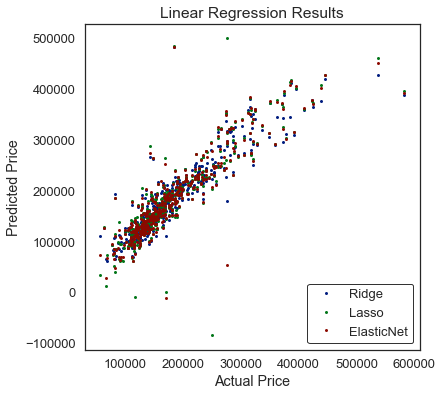

In [60]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'ElasticNet']

models = [ridgeCV, lassoCV, elasticNetCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');